<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº5
#### Joaquin Gomez Lucero y Milena Waichman Scigliano


# Introduccion


En el presente informe se aborda el análisis espectral de tres tipos de señales: un registro electrocardiográfico (ECG), un registro de pletismografía (PPG) y diversas señales de audio. El objetivo principal es caracterizar estas señales en el dominio de la frecuencia mediante la estimación de su Densidad Espectral de Potencia (PSD), empleando tres métodos no paramétricos: el periodograma ventaneado, el método de Welch y el método de Blackman–Tukey.

La **Densidad Espectral de Potencia (PSD)** describe cómo se distribuye la potencia de una señal en el dominio de la frecuencia. Este análisis resulta fundamental para identificar periodicidades y componentes espectrales que no son evidentes en la representación temporal de la señal.
Matemáticamente, la PSD puede definirse como:
$$P_x=\lim_{T \to \infty} \frac{1}{T}|X_T(f)|^2.$$
donde $X_T(f)$ representa la Transformada de Fourier de la señal truncada en un intervalo de duración $T$.
Como se mencionó previamente, existen diversos métodos para estimar la PSD; estos se describirán y aplicarán en las secciones correspondientes del informe.

Adicionalmente, se realiza una estimación del **Ancho de Banda Esencial** de cada señal. En este trabajo, se define dicho ancho de banda como el rango de frecuencias, partiendo desde 0 Hz, que contiene el 95 % de la potencia total de la señal:
$$E(f_c)=0.95 \cdot E_tot$$




# 1) Densidad Espectral de Potencia

## ECG con ruido

Para la estimación de la PSD del electrocardiograma con ruido se empleó el **método de Welch**, definido como:
$$\hat{S}_{xx}(f)=\frac{1}{K} \sum_{i=1}^{K} \frac{1}{UL}|\sum_{n=0}^{L-1}x_i[n]w[n]e^{-j2\pi fn}|^2$$
donde:
- $K$ es el número de segmentos en los que se divide la señal,
- $L$ es la longitud de cada segmento,
- $w[n]$es la ventana aplicada,
- $U$ es un factor de normalización asociado a la energía de la ventana.
Este método se caracteriza por reducir la varianza de la estimación de la PSD. El procedimiento consiste en dividir la señal en segmentos (habitualmente solapados), calcular un periodograma ventaneado para cada uno y luego promediar los resultados. Este promediado disminuye notablemente la varianza de la estimación final, aunque implica una menor resolución en frecuencia en comparación con aplicar un único periodograma a la señal completa.

En este caso, se utilizó la ventana **Flattop**, dado que el interés principal es obtener una estimación precisa de la potencia en cada frecuencia. Esta ventana presenta una amplitud de lóbulos laterales mayor y una resolución más baja, pero permite una medición más exacta de la amplitud espectral. Por lo tanto, resulta adecuada cuando se busca una buena estimación de la energía total y su distribución espectral, más que la separación de componentes muy próximas entre sí.

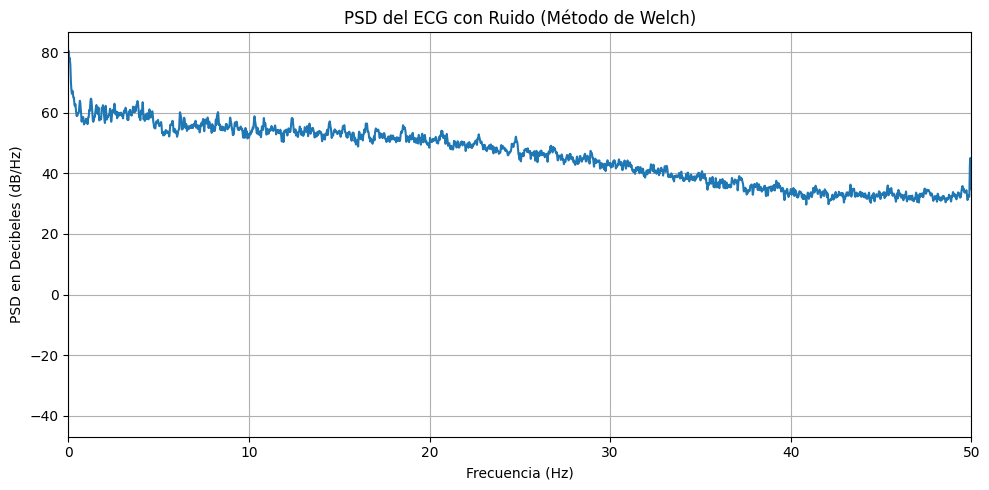

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy import signal as sig
import mne as mne


#ECG CON RUIDO analizado con Welch

fs_ecg = 1000 # Hz

sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N_ecg = len(ecg_one_lead)

cant_promedio = 15
nperseg = N_ecg // cant_promedio

ecg_one_lead = ecg_one_lead - np.mean(ecg_one_lead)

nfft = 2 * nperseg
win = "flattop"

f_ecg, PSD_ECG_W = sig.welch(ecg_one_lead, fs = fs_ecg, window=win, nperseg = nperseg, nfft = nfft )
PSD_ECG_dB = 10 * np.log10(PSD_ECG_W)

plt.figure(figsize=(10,5))
plt.plot(f_ecg, PSD_ECG_dB)
plt.title('PSD del ECG con Ruido (Método de Welch)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD en Decibeles (dB/Hz)')
plt.grid(True)
plt.xlim(0,50)
plt.tight_layout()



En el gráfico se observa el espectro de potencia expresado en decibelios (dB). A partir de él pueden identificarse tres regiones principales:

- **El Pico Principal (~80 dB)**

El punto más alto del espectro corresponde a la *deriva de línea base* de la señal. Este componente de muy baja frecuencia se origina en procesos fisiológicos lentos, como la respiración, movimientos involuntarios o cambios en la impedancia de contacto entre los electrodos y la piel.

- **La Caída de Potencia (1 a 40 Hz)**

Se aprecia con claridad cómo la potencia disminuye a medida que aumenta la frecuencia, describiendo una pendiente desde aproximadamente 0 Hz hasta 35–40 Hz. Esta región concentra la información clínicamente relevante del ECG, asociada a las ondas P, QRS y T. La pendiente refleja que la mayor parte de la energía del latido cardíaco se encuentra en las frecuencias bajas, coherente con la naturaleza periódica y relativamente lenta de la actividad cardíaca.

- **El Piso de Ruido (> 40 Hz)**

A partir de unos 40 Hz, el espectro deja de descender y se mantiene aproximadamente constante, lo que indica el *piso de ruido del sistema de adquisición*. Este nivel, en torno a los 35 dB, corresponde a ruido instrumental, interferencias electromagnéticas o actividad muscular residual. Cualquier componente espectral por debajo de este nivel se vuelve indistinguible del ruido.

### PPG con Blackman-Tukey

Para el análisis de la señal de pletismografía (PPG) con ruido se utilizó el **método de Blackman–Tukey**, definido como:
$$\hat{S}_{xx}(f)=\sum_{m=-M}^{M} \hat{r}_{xx}[m]w[m]e^{-j2\pi fm}$$
donde $\hat{r}_{xx}[m]$ es la estimación de la autocorrelación de la señal, 
$w[m]$ es la *ventana de ponderación* y $M$ representa el *retardo máximo considerado*.

Este método estima la PSD en tres etapas principales:
1. Se calcula la autocorrelación muestral de la señal.
2. Se aplica una ventana a dicha autocorrelación para limitar su extensión y reducir la varianza de la estimación.
3. Se obtiene la Transformada de Fourier de la autocorrelación ventaneada, que proporciona la estimación espectral. 

La resolución espectral del método depende del ancho efectivo de la ventana: al aumentar $M$, mejora la resolución en frecuencia pero crece la varianza de la estimación. Por tanto, existe un compromiso inverso entre resolución y varianza, típico de los métodos no paramétricos.


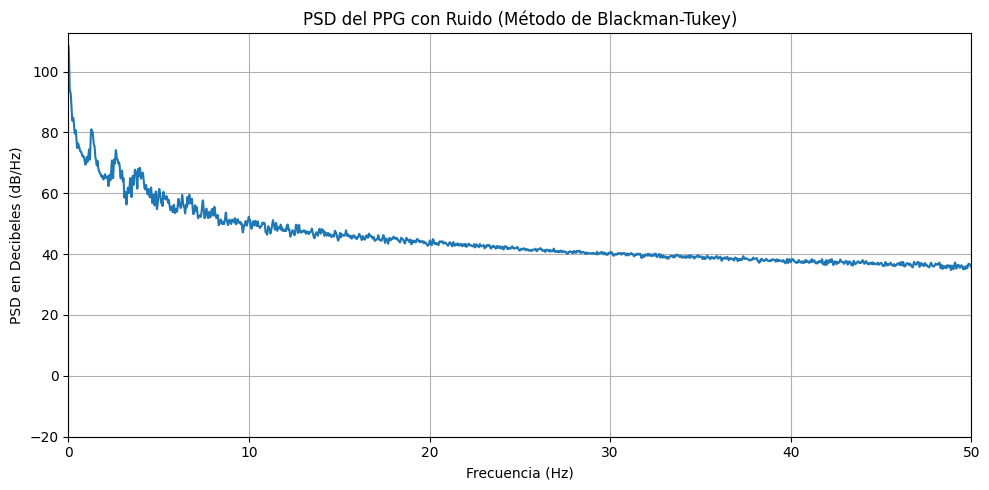

In [2]:
def blackman_tukey(x,  M = None):    
    
    #N = len(x)
    x_z = x.shape
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1
    xx = x.ravel()[:r_len];
    #autocorrelacion
    r = np.correlate(xx, xx, mode='same') / r_len
    #ventaneo
    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n = N))
    Px = Px.reshape(x_z)

    return Px;

fs_ppg = 400 # Hz

ppg = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe
N_ppg = len(ppg)

ppg = ppg - np.mean(ppg)

PSD_ppg_BT = blackman_tukey(ppg)

f_ppg = np.fft.fftfreq(N_ppg, d = 1/fs_ppg)

PSD_ppg_dB = 10 * np.log10(PSD_ppg_BT)

plt.figure(figsize=(10,5))
plt.plot(f_ppg[:N_ppg // 2], PSD_ppg_dB[:N_ppg // 2])
plt.title('PSD del PPG con Ruido (Método de Blackman-Tukey)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD en Decibeles (dB/Hz)')
plt.grid(True)
plt.xlim(0,50)
plt.ylim(bottom=-20)
plt.tight_layout()
plt.show()

En el gráfico de la PSD en dB se pueden identificar las siguientes características:

- **El Pico Fundamental (Frecuencia Cardíaca)**

El pico más prominente y dominante, ubicado entre 1 y 2 Hz, corresponde a la frecuencia cardíaca del paciente.

- **Los Armónicos**

Se observan picos secundarios en múltiplos enteros de la frecuencia fundamental. Estos armónicos surgen porque la forma de onda del pulso no es una sinusoide pura, sino una señal periódica con componentes adicionales debidas al flujo pulsátil y a la reflexión de ondas en los vasos sanguíneos periféricos. Dichos armónicos aportan información sobre la morfología del pulso y la rigidez arterial.

- **El Piso de Ruido**

A frecuencias más altas, la curva se vuelve prácticamente plana, indicando el piso de ruido del sistema de medición, estimado en torno a 45 dB. Este nivel incluye ruido electrónico del sensor, interferencias por movimiento y fluctuaciones en la luz ambiental que afectan al fotodetector.

## Audio con periodograma ventaneado
El **metodo del periodograma ventaneado** es el mas directo de los tres. Se define como:
$$\hat{S}_{xx}(f_k)=\frac{1}{N}|X(f_k)|^2$$
donde
$$X(f_k)=\sum_{n=0}^{N-1}x[n]e^{-j2\pi f_kn}$$
representa la Transformada Discreta de Fourier (DFT) de la señal $x[n]$ de longitud $N$.
El uso de una ventana busca reducir el efecto de **leakage espectral** (o fugas de energía), que ocurre cuando la señal no es perfectamente periódica dentro del intervalo de observación. Sin embargo, aplicar una ventana implica un compromiso: al disminuir el leakage se reduce la resolución espectral, por lo que la elección de la ventana es un aspecto crítico del método.

En este caso se utilizó la **ventana de Hann**, ya que ofrece una representación espectral confiable, con buena capacidad para separar tonos cercanos y una sólida supresión de lóbulos laterales, lo que minimiza la aparición de picos espurios.

A continuación se analizan las tres señales de audio empleando este método de estimación.

In [3]:
def periodograma_ventaneado (audio, fs, N_audios):
    win_audios = sig.windows.hann(N_audios)
    f_win, Periodograma_win = sig.periodogram(audio, fs = fs, window = win_audios, scaling='density')
    Periodograma_win_dB = 10 * np.log10(Periodograma_win)
    
    return f_win, Periodograma_win, Periodograma_win_dB

### "La cucaracha"

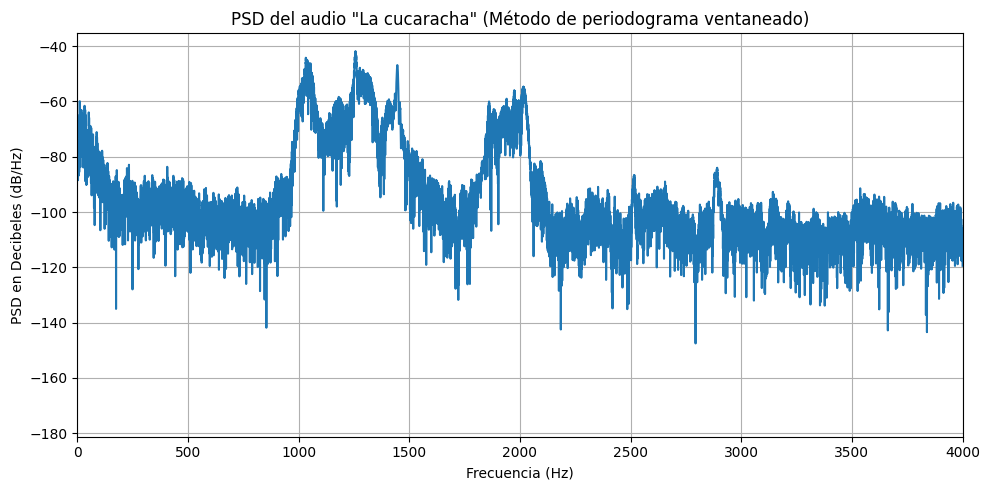

In [4]:
fs_cuca, wav_data_cuca = sio.wavfile.read('lacucaracha.wav')
audio_cuca = wav_data_cuca.astype(float)
audio_cuca = audio_cuca - np.mean(audio_cuca)
N_cuca = len(audio_cuca)

f_cuca, PSD_cuca, PSD_cuca_dB = periodograma_ventaneado(audio_cuca, fs = fs_cuca, N_audios = N_cuca)

plt.figure(figsize=(10,5))
plt.plot(f_cuca, PSD_cuca_dB)
plt.title('PSD del audio "La cucaracha" (Método de periodograma ventaneado)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD en Decibeles (dB/Hz)')
plt.grid(True)
plt.xlim(0,4000)
plt.tight_layout()
plt.show()

En el periodograma pueden distinguirse las siguientes características:
- **Múltiples Picos = Múltiples Notas**

Se observan varios grupos de picos de alta energía en distintas regiones del espectro. Cada grupo (por ejemplo, entre 1000 y 1500 Hz y alrededor de 2000 Hz) corresponde a las *frecuencias fundamentales* de diferentes notas musicales presentes en la señal. Estas frecuencias marcan los *tonos principales* de la melodía.

- **Armónicos**

Dentro de cada grupo, el pico más alto representa la frecuencia fundamental de la nota, mientras que los picos secundarios que la acompañan corresponden a sus armónicos. Estos armónicos son múltiplos enteros de la frecuencia fundamental y determinan el timbre del sonido.

### Sonido de prueba

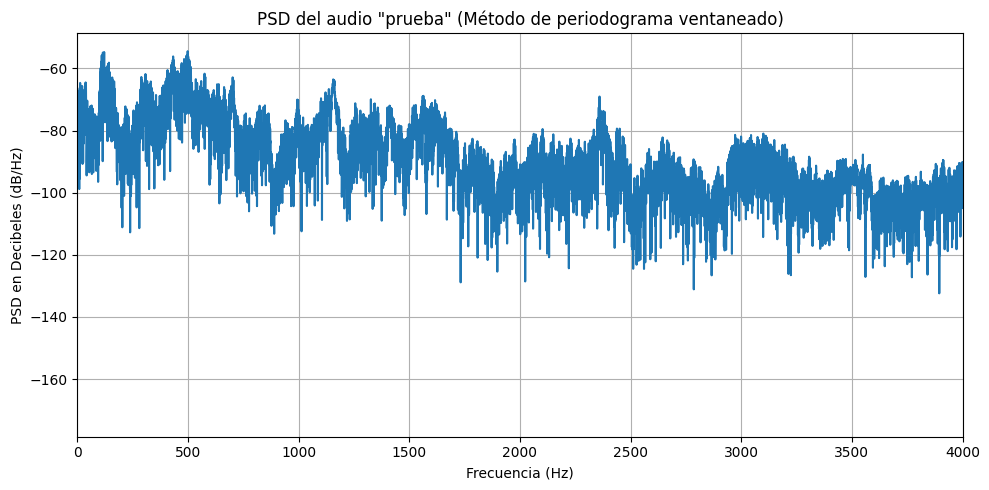

In [5]:
fs_prueba, wav_data_prueba = sio.wavfile.read('prueba psd.wav')
audio_prueba = wav_data_prueba.astype(float)
audio_prueba = audio_prueba - np.mean(audio_prueba)
N_prueba = len(audio_prueba)

f_prueba, PSD_prueba, PSD_prueba_dB = periodograma_ventaneado(audio_prueba, fs = fs_prueba, N_audios = N_prueba)

plt.figure(figsize=(10,5))
plt.plot(f_prueba, PSD_prueba_dB)
plt.title('PSD del audio "prueba" (Método de periodograma ventaneado)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD en Decibeles (dB/Hz)')
plt.grid(True)
plt.xlim(0,4000)
plt.tight_layout()
plt.show()

En el periodograma puede observarse la descomposición de los componentes que conforman el sonido de la voz humana:

- **Naturaleza de Banda Ancha**

A diferencia de una melodía instrumental o un silbido, la voz hablada no concentra su energía en unas pocas frecuencias discretas. En cambio, presenta una distribución continua de energía a lo largo del espectro, característica de una señal de banda ancha. Esto se debe a la compleja modulación producida por las cuerdas vocales y el tracto vocal durante el habla.

- **Frecuencia Fundamental**

A diferencia de una melodía instrumental o un silbido, la voz hablada no concentra su energía en unas pocas frecuencias discretas. En cambio, presenta una distribución continua de energía a lo largo del espectro, característica de una señal de banda ancha. Esto se debe a la compleja modulación producida por las cuerdas vocales y el tracto vocal durante el habla.

- **Armónicos y Formantes**

En frecuencias superiores se observan picos y regiones amplias de energía que corresponden a los armónicos y formantes de la señal.
Los armónicos son múltiplos enteros de la frecuencia fundamental y aportan riqueza espectral al timbre de la voz.
Los formantes, en cambio, son resonancias del tracto vocal que modelan el sonido generado por las cuerdas vocales. Cada vocal posee un patrón característico de formantes, lo que permite distinguir sonidos como las vocales incluso con la misma frecuencia fundamental.

### Silbido

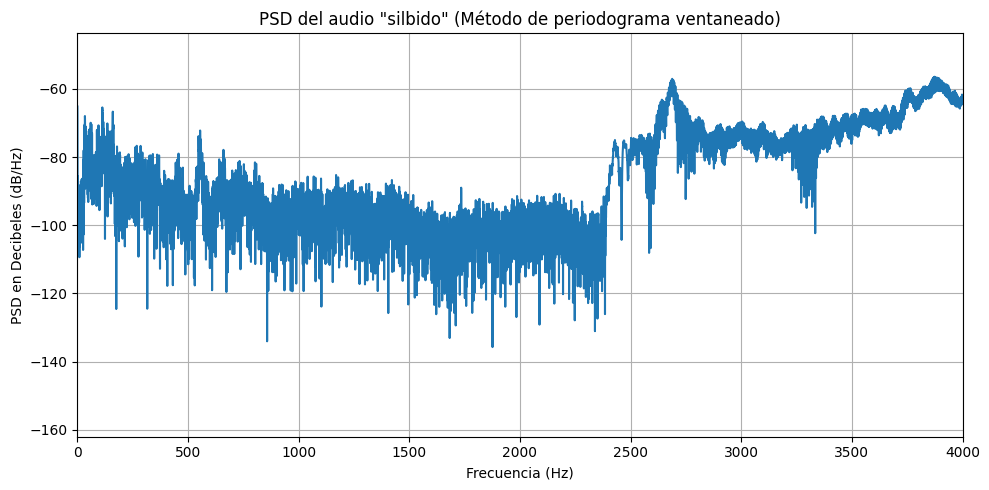

In [7]:
fs_silbido, wav_data_silbido = sio.wavfile.read('silbido.wav')
audio_silbido = wav_data_silbido.astype(float)
audio_silbido = audio_silbido - np.mean(audio_silbido)
N_silbido = len(audio_silbido)

f_silbido, PSD_silbido, PSD_silbido_dB = periodograma_ventaneado(audio_silbido, fs = fs_silbido, N_audios = N_silbido)

plt.figure(figsize=(10,5))
plt.plot(f_silbido, PSD_silbido_dB)
plt.title('PSD del audio "silbido" (Método de periodograma ventaneado)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD en Decibeles (dB/Hz)')
plt.grid(True)
plt.xlim(0,4000)
plt.tight_layout()
plt.show()

En este caso, al tratarse de un silbido humano, el periodograma no es muy claro debido al fuerte componente ruidoso que genera el soplido. Esto puede analizarse así:
- **El Componente Tonal**

Corresponde a la parte del sonido que se percibe como una nota musical. Es una vibración del aire a una frecuencia bien definida. En una PSD ideal, este componente aparece como un pico estrecho y pronunciado. En el gráfico actual, dicho pico tonal es débil o está enmascarado por el ruido.

- **El Componente Ruidoso**

Al silbar, el aire se fuerza a través de una abertura muy pequeña entre los labios, lo que produce turbulencia. Este flujo de aire turbulento genera un ruido de banda ancha, con energía distribuida en una gran variedad de frecuencias —sobre todo en las más altas—. En este caso, el gran aumento de energía que se observa a partir de los 2500 Hz corresponde al sonido del aire turbulento.
La apariencia extremadamente “picuda” y caótica del periodograma refleja la alta varianza de este tipo de estimación: el periodograma responde de forma muy sensible a la naturaleza aleatoria del ruido, amplificando las fluctuaciones instantáneas del espectro.

# 2) Estimacion del Ancho de Banda Esencial

A continuación se estima el ancho de banda esencial de cada una de las señales analizadas. Para ello, se calculó la energía total de la señal y se determinó la energía de corte correspondiente al 95 % de la energía acumulada, con el fin de identificar el rango de frecuencias que contiene la mayor parte de la potencia de la señal.

Es importante destacar que un ancho de banda reducido indica que la energía de la señal se concentra principalmente en las frecuencias bajas, mientras que un ancho de banda amplio sugiere que la potencia se distribuye a lo largo de un espectro más extenso. Este parámetro permite comparar la complejidad espectral de distintas señales y evaluar qué tan “rápidas” o “densas” son sus variaciones temporales.

In [8]:
def estimacion_bw (freq, PSD, porcentaje):
    df = freq[1] - freq[0]
    en_acum = np.cumsum(PSD * df)
    en_tot = en_acum[-1] #la energia total es el ultimo valor del acum
    en_corte = en_tot * porcentaje
    
    indice_corte = np.where(en_acum >= en_corte)[0][0]
    freq_BW = freq[indice_corte]
    
    return freq_BW
    
#para BT hay que calcular en el eje positivo solamente
f_ppg_positivo = f_ppg[:N_ppg // 2]
PSD_ppg_BT_positivo = PSD_ppg_BT[:N_ppg // 2]

BW_ECG = estimacion_bw (freq = f_ecg, PSD = PSD_ECG_W , porcentaje = 0.95)
BW_PPG = estimacion_bw (freq = f_ppg_positivo, PSD = PSD_ppg_BT_positivo , porcentaje = 0.95)
BW_cuca = estimacion_bw (freq = f_cuca, PSD = PSD_cuca , porcentaje = 0.95)
BW_prueba = estimacion_bw (freq = f_prueba, PSD = PSD_prueba , porcentaje = 0.95)
BW_silbido = estimacion_bw (freq = f_silbido, PSD = PSD_silbido , porcentaje = 0.95)

print("BW ECG:", BW_ECG)
print("BW PPG:", BW_PPG)
print("BW La cucaracha:", BW_cuca)
print("BW prueba:", BW_prueba)
print("BW silbido:", BW_silbido)

BW ECG: 18.904269734569706
BW PPG: 0.141221121383967
BW La cucaracha: 1861.6666666666665
BW prueba: 1406.6666666666665
BW silbido: 6414.0


Con los anchos de banda calculados se construyó la siguiente tabla comparativa:


| Tipo de Señal           | Método de PSD Utilizado | Ancho de Banda (Hz)         |
|:------------------------|:------------------------|:----------------------------|
| ECG en esfuerzo         | Welch                   | 18.90                       |
| PPG en reposo           | Blackman-Tukey          | 0.14                        |
| Audio: La Cucaracha     | Periodograma            | 1861.66                     |
| Audio: Voz (Prueba)     | Periodograma            | 1406.66                     |
| Audio: Silbido          | Periodograma            | 6414.00                     |

Como puede observarse, los anchos de banda de las señales de audio son significativamente mayores que los de las señales biomédicas. Esto refleja la naturaleza de cada señal: mientras que las señales de audio representan vibraciones rápidas del aire, las señales biomédicas corresponden a procesos fisiológicos lentos, cuya energía se concentra en frecuencias bajas.

Es importante destacar el resultado del PPG, cuyo ancho de banda calculado es extremadamente bajo. Este valor no representa el ancho de banda real del pulso, sino que indica que la señal está dominada por la deriva de línea base. La energía generada por este artefacto es tan alta que satura el cálculo del 95 % de la energía total, dando lugar a un ancho de banda muy reducido. Una forma de obtener una estimación más precisa sería aplicar un filtro a la señal para eliminar la deriva y luego recalcular el ancho de banda esencial.

# BONUS

Como complemento del trabajo, se analizó una señal de **Electromiografía (EMG)** tomada del registro *brux1.edf* del [CAP Sleep Database](https://physionet.org/content/capslpdb/1.0.0/). La EMG refleja la actividad eléctrica de los músculos durante su contracción y se caracteriza por ser una señal de banda ancha, con energía distribuida principalmente entre 20 y 450 Hz y con un comportamiento más ruidoso que el ECG o PPG.

La señal fue digitalizada en el estudio original mediante un sistema de adquisición EEG/EMG con frecuencia de muestreo de 400 Hz, y se encuentra disponible en formato EDF. Se seleccionó el canal EMG1-EMG2 y se extrajo la señal digitalizada. El objetivo fue analizarla en el dominio de la frecuencia usando el **método de Welch** para estimar la Densidad Espectral de Potencia (PSD) y calcular el Ancho de Banda Esencial que contiene el 95 % de la energía, permitiendo cuantificar la extensión del espectro donde se concentra la mayor parte de la actividad muscular.


Extracting EDF parameters from C:\Users\Milena\Documents\Facultad\APS\TS_GL_WS\brux1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7342591  =      0.000 ... 14340.998 secs...


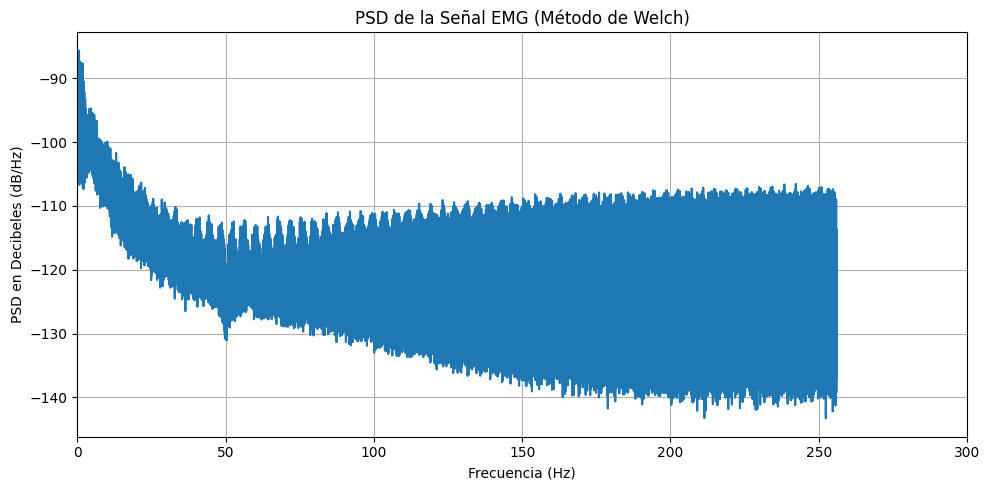

El ancho de banda esencial del EMG es:  87.45836006095942


In [11]:
#BONUS
import warnings
warnings.filterwarnings('ignore') #esto lo agregamos pq la señal fue mal grabada y tira un par de warnings

raw = mne.io.read_raw_edf('brux1.edf', preload = True)

emg = raw.copy().pick(['EMG1-EMG2'])

emg_data = emg.get_data()[0]
fs_emg = int(emg.info['sfreq'])
N_emg = len(emg_data)

cant_promedio_emg = 15
nperseg_emg = N_emg // cant_promedio_emg
#nfft_emg = 2 * nperseg
win_emg = 'hann'

#calculo PSD con WELCH
f_emg, PSD_EMG_W = sig.welch(emg_data, fs = fs_emg, window = win_emg, nperseg = nperseg_emg)
PSD_EMG_dB = 10 * np.log10(PSD_EMG_W)

plt.figure(figsize=(10,5))
plt.plot(f_emg, PSD_EMG_dB)
plt.title('PSD de la Señal EMG (Método de Welch)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD en Decibeles (dB/Hz)')
plt.grid(True)
plt.xlim(0,300)  # EMG tiene energía hasta ~450 Hz
plt.tight_layout()
plt.show()

#calculo BW
BW_EMG = estimacion_bw (freq = f_emg, PSD = PSD_EMG_W , porcentaje = 0.95)

print("El ancho de banda esencial del EMG es: ", BW_EMG)

La PSD del EMG muestra varias características típicas:

- **Artefactos de baja frecuencia**

Se observa un pico cerca de 0 Hz, asociado a movimientos o desplazamiento de electrodos sobre la piel.

- **Lóbulo principal de potencia (20–150 Hz)**

La mayor parte de la energía se concentra en este rango, reflejando la actividad rápida y compleja de las unidades motoras del músculo. A diferencia de ECG y PPG, cuya energía está en frecuencias bajas, la EMG es de banda ancha.

- **Caída en ~250 Hz**

La energía de la señal disminuye notablemente a partir de ~250 Hz. Esto indica que la actividad muscular registrada se concentra principalmente por debajo de esa frecuencia, mientras que en frecuencias más altas la señal contiene poca energía y está más cercana al nivel de ruido.

El **ancho de banda esencial** calculado fue ≈87,45 Hz, lo que indica que el 95 % de la energía se encuentra por debajo de esa frecuencia. Esto lo sitúa entre señales biomédicas lentas como el ECG (~19 Hz) y rápidas como el audio, destacando su carácter de frecuencia intermedia.

# Conclusion

En este informe se analizaron señales de distinta naturaleza —biomédicas (ECG y PPG) y acústicas (tres grabaciones de audio)— mediante la estimación de su **densidad espectral de potencia (PSD)** y el cálculo de su **ancho de banda esencia**l. Se aplicaron tres métodos no paramétricos: **Welch, Blackman–Tukey y periodograma ventaneado**, elegidos según las características de cada señal y la precisión requerida en la medición de potencia.

El análisis espectral permitió identificar las características más relevantes de cada señal. En el ECG, la energía se concentra principalmente en bajas frecuencias, asociadas a las ondas P, QRS y T, mientras que el piso de ruido aparece a partir de ~40 Hz. En la PPG, el espectro muestra un pico fundamental correspondiente a la frecuencia cardíaca y armónicos más débiles, aunque la señal estuvo dominada por la deriva de línea base, lo que redujo artificialmente el ancho de banda esencial.

En las señales de audio, el periodograma permitió distinguir claramente las frecuencias fundamentales y sus armónicos en la música y la voz, así como la presencia de formantes en la voz hablada. En el caso del silbido, el componente tonal fue opacado por un ruido de banda ancha generado por el flujo turbulento de aire, evidenciando la sensibilidad del periodograma ante señales ruidosas. Los anchos de banda esenciales calculados reflejan estas diferencias: las señales acústicas presentaron valores mucho mayores que las biomédicas, coherentes con la naturaleza rápida y compleja de las vibraciones del aire frente a los procesos fisiológicos lentos.

El análisis de la señal EMG complementa los resultados del informe, mostrando una señal biomédica de banda ancha y frecuencia intermedia. A diferencia del ECG y la PPG, cuya energía se concentra en frecuencias bajas, la EMG presenta un lóbulo principal de potencia entre 20 y 150 Hz, reflejando la complejidad de la actividad muscular. Su ancho de banda esencial de 87,45 Hz confirma que gran parte de la energía se concentra en este rango, posicionándola entre las señales fisiológicas lentas y las señales de audio rápidas. Este resultado resalta cómo la naturaleza fisiológica de cada señal determina su distribución espectral y refuerza la importancia de analizar la PSD para caracterizar distintos tipos de señales.

En conjunto, estos resultados muestran cómo la PSD y el ancho de banda esencial son herramientas poderosas para caracterizar señales de distinta naturaleza, identificar componentes relevantes y comprender cómo se distribuye la energía a lo largo del espectro. Además, resaltan la importancia de elegir el método de estimación y la ventana adecuada, según el tipo de señal y el objetivo del análisis.


## Autoevaluacion

*Indicar una opción (marcada con negrita):*

**1. Resolví la tarea con seguridad**
2. Resolví la tarea, pero tengo dudas
3. Resolví la tarea,pero no entendí bien
4. No pude resolverla y no entendí


Responder:

*¿Qué aprendiste al hacer esta tarea?*

En esta tarea aprendimos a utilizar métodos de estimación de PSD y cuales son los beneficios y limitaciones de cada uno. También pudimos ver los efectos de esta estimación en señales de distinto origen, como pueden ser las señales biomédica y señales de audio. Por ultimo, pudimos comprender como se calcula el ancho de banda esencial y porque es útil contar con esta información.

*¿Qué te quedó claro? ¿Qué te sigue costando?*

Quedo todo claro!

*Indicar si se utilizó IA:*

**Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.**
No usé IA.
*En caso afirmativo, indicar una opción o varias:*

**Escritura**

**Código**

**Conceptos teorícos**

**Gráficos**

Conclusiones